### Library install :
- Python : `3.6`
- `conda install numpy`
- `conda install matplotlib`
- `conda install pandas`
- `conda instal scikit-learn`
- Opsi Tensorflow (**pilih salah satu**) :
    - `pip install tensorflow-gpu==1.12 --user` --> TF GPU | CUDA 9.0 | CuDNN 7.0 | GPU Driver Ver >= 385.xx
    - `pip install tensorflow-gpu==2.1 --user` --> TF GPU | CUDA 10.0 | CuDNN 7.6 | GPU Driver Ver >= 411.xx
    - `pip install tensorflow==2.1 --user` --> TF CPU
- `conda install keras`
- `conda install -c conda-forge ipykernel`

In [1]:
import os
# if GPU is not available, just disable GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
        filenames.append(filename)

In [2]:
filenames

['balanced_mitbih_train.csv',
 'ECG-01-C1-15-10-2020-14-47(Nicol).csv',
 'ECG-01-C2-15-10-2020-14-47(Nicol).csv',
 'ECG-01-C3-15-10-2020-14-47(Nicol).csv',
 'mitbih_test.csv',
 'mitbih_train.csv']

In [3]:
# check available GPU
import tensorflow as tf

# tensorflow  2.x 
#tf.config.list_physical_devices('GPU') 

# tensorflow 1.x
with tf.Session() as sess:
    print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 18210541351768355240), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1502406247, 12340088351371614339)]


In [4]:
tf.__version__

'1.12.0'

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [6]:
train_df=pd.read_csv(dataset_folder + 'balanced_mitbih_train.csv',header=None)
test_df=pd.read_csv(dataset_folder + 'mitbih_test.csv',header=None)

## Dataset MIT-BIH
Dataset MIT-BIH terdiri dari 188 kolom, dimana kolom ke 188 merupakan katerori/class.

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


___
## Add Noise

- pada bagian ini kita tambahkan gaussian noise pada signal ECG 
- Noise yang akan ditambahkan adalah **Additive White Gaussian Noise (AWGN)**.
- Pada AWGN nilai rata-rata $\mu$ = 0, sehingga untuk tiap Gaussian random variable $X$, non-central second [moment](https://en.wikipedia.org/wiki/Normal_distribution#Moments) *E*[$X^{2}$] adalah: <br><br>
*E*[$X^{2}$] = $\mu^{2}$ + $\sigma^{2}$ <br><br>
sehingga, <br>
*E*[$X^{2}$] = $\sigma^{2}$ <br><br>
untuk, <br>
*E*[$X^{2}$] dalam konteks ini merupakan rata-rata noise, <br><br>
$NoiseAvg$ = $10^{NoiseAvg[db]/10}$ <br><br>
konversi baliknya ke-db, <br>
$NoiseAvg[db] = 10\times log(NoiseAvg)$ <br><br>
NoiseAvg bisa didapatkan dari formula $SNR$, <br>
$SNR[db]= Signal[db] - NoiseAvg[db]$ 
<br><br>
sehingga jika $SNR$ diset pada nilai tertentu, bisa didapatkan variance $\sigma^{2}$ yang nantinya dapat digunakan untuk menghasilkan white noise. 
- untuk menghasilkan white noise bisa digunakan library `numpy.random.normal()` dengan parameter `step` = $\sigma$ (std deviation)

In [8]:
def add_AWGN_noise(signal, target_snr_db=18):
    
    # Calculate signal and convert to dB 
    sig_avg = np.mean(signal)
    sig_avg_db = 10 * np.log10(sig_avg)
    
    # Calculate noise : 
    # SNR_db = Signal_db - Noise_db
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    
    # Generate an sample of white noise
    mean_noise = 0
    sigma = np.sqrt(noise_avg_watts)
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [9]:
def plot_noised_signal(signal, noised_signal):
    plt.figure(figsize=(15,4)) 

    plt.subplot(1,2,1)
    plt.plot(signal)
    plt.title("Original Signal")

    plt.subplot(1,2,2)
    plt.plot(noised_signal)
    plt.title("Noised Signal with AWGN")

    plt.tight_layout()
    plt.show()

### Add Noise to All Signal Dataset

In [10]:
X_train=train_df.iloc[:,:187].values
X_test=test_df.iloc[:,:187].values

In [11]:
X_train_noised = train_df.iloc[:,:187].apply(add_AWGN_noise, axis=1).values
X_test_noised = test_df.iloc[:,:187].apply(add_AWGN_noise, axis=1).values

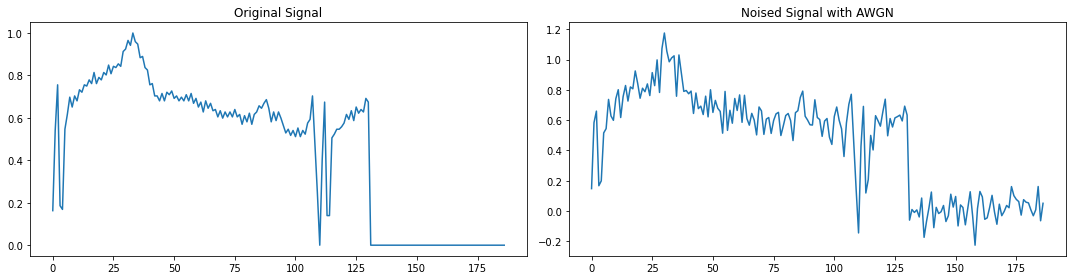

In [12]:
plot_noised_signal(X_train[0], X_train_noised[0])

___
# Denoising Signal

- Ditahap ini kita akan coba lakukan Denoising signal menggunakan Deep Learning
    - CNN (Convolutional Neural Network)
    - LSTM (Long-Short Term Memory)
    - DAE (Denoising Auto Encoder)
- Sumber : [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html) <br>
![](resource/DAE.png)

#### Visualization util

In [13]:
def plot_model_history(history):
    
    fig, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

In [14]:
def plot_decoded_signal(decoded_signal, original_signal, name):
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.plot(decoded_signal)
    plt.title("Denoised Signal - " + name)

    plt.subplot(1,2,2)
    plt.plot(original_signal)
    plt.title("Original Signal")

    plt.tight_layout()
    plt.show()

#### Custom loss 

In [15]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### Denoising Deep Autoencoder

In [16]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


In [17]:
X_train = X_train.reshape(len(X_train), X_train.shape[1])
X_test = X_test.reshape(len(X_test), X_test.shape[1])
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1])
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1])

In [18]:
def DeepAutoEncoder(input_dim):
    autoencoder = Sequential(name="deep_autoencoder")
    autoencoder.add(InputLayer(input_shape=(input_dim,))) 
    autoencoder.add(Dense(128, activation='relu', name="encode_1"))
    autoencoder.add(Dense(64, activation='relu', name="encode_2"))
    autoencoder.add(Dense(32, activation='relu', name="encode_3"))
    
    autoencoder.add(Dense(64, activation='relu', name="decode_1"))
    autoencoder.add(Dense(128, activation='relu', name="decode_2"))
    autoencoder.add(Dense(input_dim, activation='sigmoid', name="decode_3"))
    autoencoder.summary()
    
    autoencoder.compile(
                        optimizer = 'adam', 
                        loss = rmse)
    return autoencoder

In [19]:
model_name_deep_AE = 'best_denoising_deep_AE.h5'
input_dim = X_train_noised.shape[1]
deep_autoencoder = DeepAutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(
                         filepath = model_name_deep_AE, 
                         monitor = 'val_loss',
                         save_best_only = True)]

history = deep_autoencoder.fit(X_train_noised, X_train,
                        epochs = 50,
                        batch_size = 64,
                        callbacks = callbacks,
                        shuffle = True,
                        validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (Dense)             (None, 128)               24064     
_________________________________________________________________
encode_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
encode_3 (Dense)             (None, 32)                2080      
_________________________________________________________________
decode_1 (Dense)             (None, 64)                2112      
_________________________________________________________________
decode_2 (Dense)             (None, 128)               8320      
_________________________________________________________________
decode_3 (Dense)             (None, 187)               24123     
Total params: 68,955
Trainable params: 68,955
Non-trainable params: 0
_________________________________________________________________
Train 

In [71]:
deep_autoencoder.save(model_name_deep_AE)

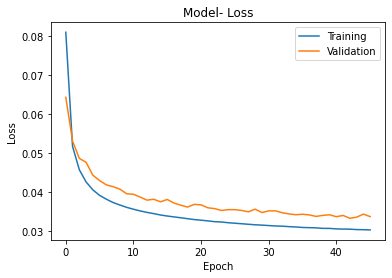

In [20]:
plot_model_history(history)

In [22]:
decoded_ecgs = deep_autoencoder.predict(X_test_noised)

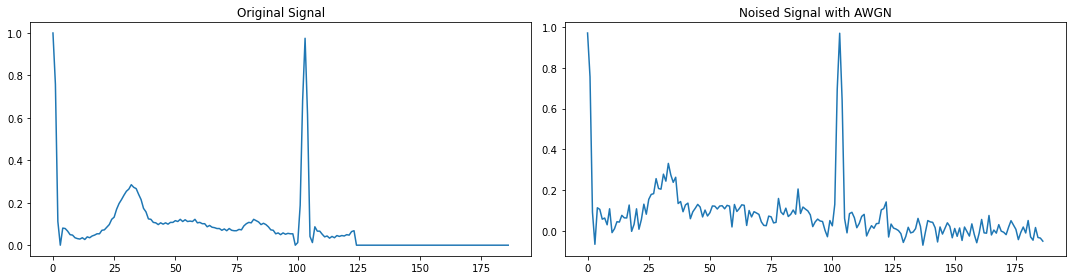

In [23]:
plot_noised_signal(X_test[0], X_test_noised[0])

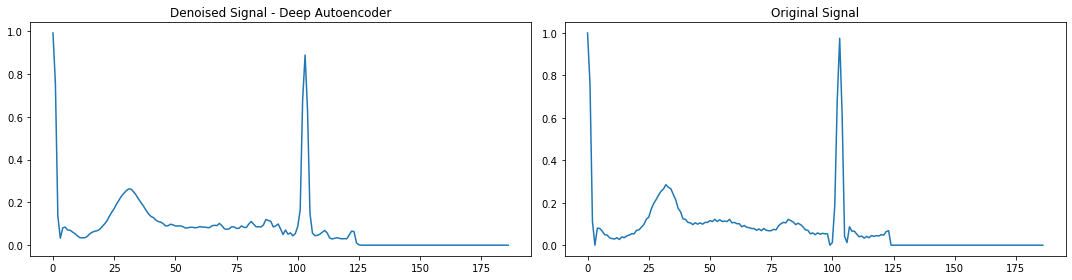

In [24]:
plot_decoded_signal(decoded_ecgs[0], X_test[0],"Deep Autoencoder")

### Denoising CNN - Autoencoder

In [37]:
from keras.layers import Conv1D, MaxPooling1D as MaxP1D, UpSampling1D as UpSm1D

In [56]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1], 1)
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1], 1)

X_train = X_train[:,:184,:]
X_test = X_test[:,:184,:]
X_train_noised = X_train_noised[:,:184,:]
X_test_noised = X_test_noised[:,:184,:]

In [38]:
def ConvAutoEncoder(input_dim):
    conv_net = Sequential(name="conv_autoencoder")
    conv_net.add(InputLayer(input_shape=(input_dim,1))) 
    
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="encode_1"))
    conv_net.add(MaxP1D(2, padding='same', name="encode_2"))
    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="encode_3"))
    conv_net.add(MaxP1D(2, padding='same', name="encode_4"))
#     conv_net.add(Conv1D(32, 3, activation='relu', padding='same', name="encode_5"))
#     conv_net.add(MaxP1D(2, padding='same', name="encode_6"))
    
#     conv_net.add(Conv1D(32, 3, activation='relu', padding='same', name="decode_1"))
#     conv_net.add(UpSm1D(2, name="decode_2"))
    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="decode_3"))
    conv_net.add(UpSm1D(2, name="decode_4"))
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="decode_5"))
    conv_net.add(UpSm1D(2, name="decode_6"))
    conv_net.add(Conv1D(1, 3, activation='sigmoid', padding='same', name="decode_7"))

    conv_net.summary()
    
    conv_net.compile(
                    optimizer = 'adam', 
                    loss = rmse)
    
    return conv_net

In [39]:
model_name_conv_AE = 'best_denoising_conv_AE.h5'

input_dim = X_train_noised.shape[1]
conv_autoencoder = ConvAutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(
                         filepath = model_name_conv_AE, 
                         monitor = 'val_loss', 
                         save_best_only = True)]

history = conv_autoencoder.fit(X_train_noised, X_train,
                                epochs = 50,
                                batch_size = 64,
                                shuffle = True,
                                callbacks = callbacks,
                                validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (Conv1D)            (None, 184, 128)          512       
_________________________________________________________________
encode_2 (MaxPooling1D)      (None, 92, 128)           0         
_________________________________________________________________
encode_3 (Conv1D)            (None, 92, 64)            24640     
_________________________________________________________________
encode_4 (MaxPooling1D)      (None, 46, 64)            0         
_________________________________________________________________
decode_3 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
decode_4 (UpSampling1D)      (None, 92, 64)            0         
_________________________________________________________________
decode_5 (Conv1D)            (None, 92, 128)           24704     
__________

In [60]:
# conv_autoencoder.save(model_name_conv_AE)

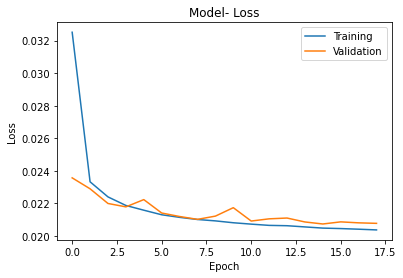

In [40]:
plot_model_history(history)

In [41]:
decoded_ecgs = conv_autoencoder.predict(X_test_noised)

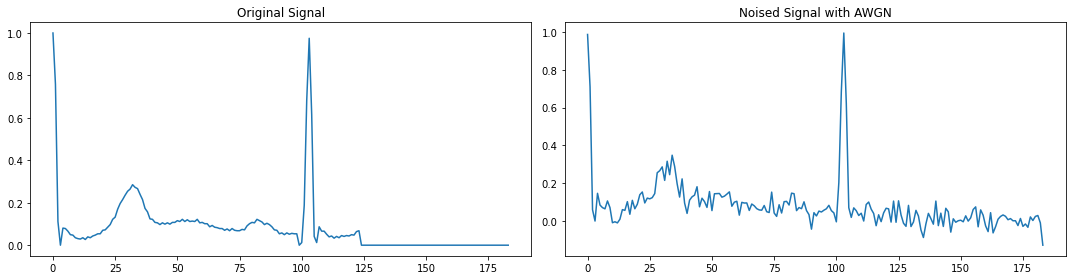

In [42]:
plot_noised_signal(X_test[0], X_test_noised[0])

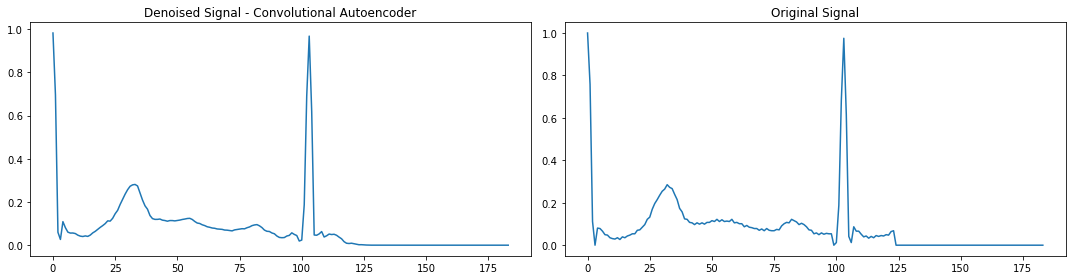

In [43]:
plot_decoded_signal(decoded_ecgs[0], X_test[0],"Convolutional Autoencoder")

### Denoising LSTM - Autoencoder (Sequence to Sequence)

In [17]:
from keras.layers import LSTM, RepeatVector, CuDNNLSTM, TimeDistributed


In [18]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1], 1)
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1], 1)

X_train = X_train[:,:184,:]
X_test = X_test[:,:184,:]
X_train_noised = X_train_noised[:,:184,:]
X_test_noised = X_test_noised[:,:184,:]

In [20]:
def LSTM_AutoEncoder(input_dim):
    lstm = Sequential(name="lstm_autoencoder")
    lstm.add(InputLayer(input_shape=(input_dim,1))) 
    
    lstm.add(CuDNNLSTM(100, name="encode_1"))

    lstm.add(RepeatVector(input_dim, name="decode_1"))
    lstm.add(CuDNNLSTM(100, return_sequences=True, name="decode_2"))
    lstm.add(TimeDistributed(Dense(1, activation="sigmoid")))
    
    lstm.summary()
    
    lstm.compile(
                optimizer = 'adam', 
                loss = rmse)
    
    return lstm

In [21]:
model_name_LSTM_AE = 'best_denoising_LSTM_AE.h5'

input_dim = X_train_noised.shape[1]
lstm_autoencoder = LSTM_AutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(
                         filepath = model_name_LSTM_AE, 
                         monitor = 'val_loss', 
                         save_best_only = True)]

history = lstm_autoencoder.fit(X_train_noised, X_train,
                                epochs = 50,
                                batch_size = 64,
                                callbacks = callbacks,
                                shuffle = True,
                                validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (CuDNNLSTM)         (None, 100)               41200     
_________________________________________________________________
decode_1 (RepeatVector)      (None, 184, 100)          0         
_________________________________________________________________
decode_2 (CuDNNLSTM)         (None, 184, 100)          80800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 184, 1)            101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
Train on 100000 samples, validate on 21892 samples
Epoch 1/50
100000/100000 [==============================] - 237s 2ms/step - loss: 0.1553 - val_loss: 0.1151
Epoch 2/50
100000/100000 [==============================] - 230s 2ms/step - loss: 0.1078 - val_loss: 0.1028
E

In [22]:
lstm_autoencoder.save(model_name_LSTM_AE)

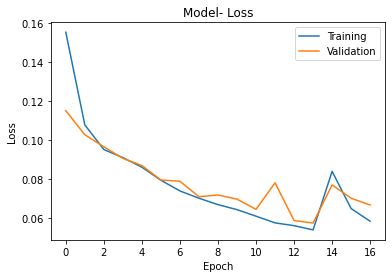

In [23]:
plot_model_history(history)

In [24]:
decoded_ecgs = lstm_autoencoder.predict(X_test_noised)

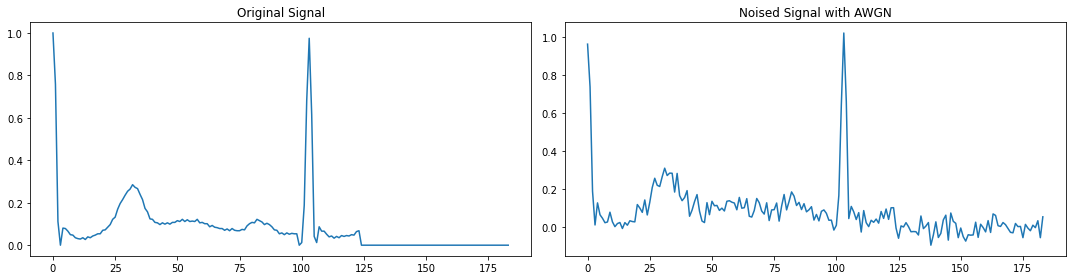

In [25]:
plot_noised_signal(X_test[0], X_test_noised[0])

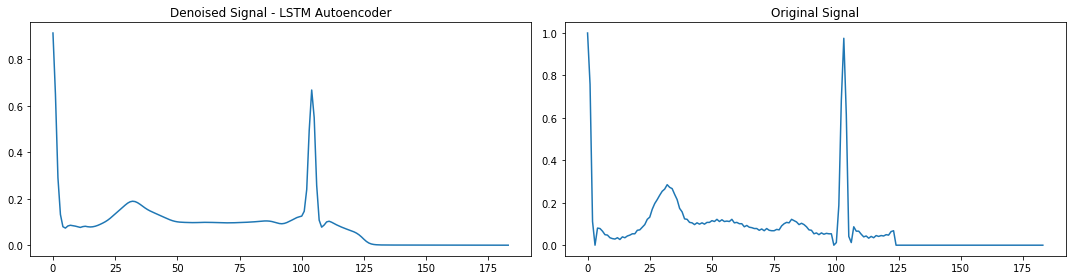

In [26]:
plot_decoded_signal(decoded_ecgs[0], X_test[0],"LSTM Autoencoder")